In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("RELIANCE.csv")

df = df.sort_index()
df = df.reset_index(drop=True)

df['Close'] = df['Close'].astype(float)
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=5).std()   # 5-day rolling volatility
df['Next_Close'] = df['Close'].shift(-1)
df['Next_Vol'] = df['Return'].rolling(window=5).std().shift(-1)
df['Direction'] = (df['Next_Close'] > df['Close']).astype(int)

df.dropna(inplace=True)
df = df.reset_index(drop=True)

feature_cols = ['Close', 'Return', 'Volatility']
reg_target_cols = ['Next_Close', 'Next_Vol']
dir_col = 'Direction'

features_all = df[feature_cols].values
targets_reg_all = df[reg_target_cols].values
targets_dir_all = df[dir_col].values

N = len(df)
train_frac = 0.7
val_frac = 0.15

train_end = int(N * train_frac)
val_end = int(N * (train_frac + val_frac))

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_scaler.fit(features_all[:train_end])
target_scaler.fit(targets_reg_all[:train_end])

features_scaled = feature_scaler.transform(features_all)
targets_reg_scaled = target_scaler.transform(targets_reg_all)
targets_dir = targets_dir_all.copy()

def create_sequences_from_full(scaled_features, scaled_targets_reg, targets_dir, seq_len):

    X, y_reg, y_dir_out, idxs = [], [], [], []
    N_all = len(scaled_features)
    for i in range(seq_len, N_all):
        X.append(scaled_features[i-seq_len:i])
        y_reg.append(scaled_targets_reg[i])
        y_dir_out.append(targets_dir[i])
        idxs.append(i)
    return np.array(X), np.array(y_reg), np.array(y_dir_out), np.array(idxs)

seq_len = 60
X_all, y_reg_all, y_dir_all, idxs = create_sequences_from_full(features_scaled, targets_reg_scaled, targets_dir, seq_len)



train_mask = idxs < train_end
val_mask   = (idxs >= train_end) & (idxs < val_end)
test_mask  = idxs >= val_end

X_train, y_reg_train, y_dir_train = X_all[train_mask], y_reg_all[train_mask], y_dir_all[train_mask]
X_val,   y_reg_val,   y_dir_val   = X_all[val_mask],   y_reg_all[val_mask],   y_dir_all[val_mask]
X_test,  y_reg_test,  y_dir_test  = X_all[test_mask],  y_reg_all[test_mask],  y_dir_all[test_mask]

inp = Input(shape=(seq_len, X_train.shape[2]))
x = SimpleRNN(64, return_sequences=True)(inp)
x = Dropout(0.25)(x)
x = SimpleRNN(32)(x)
x = Dropout(0.2)(x)


out_price = Dense(1, name='price')(x)
out_vol   = Dense(1, name='vol')(x)

out_dir   = Dense(1, activation='sigmoid', name='dir')(x)

model = Model(inputs=inp, outputs=[out_price, out_vol, out_dir])
model.compile(optimizer='adam',
              loss={'price': 'mse', 'vol': 'mse', 'dir': 'binary_crossentropy'},
              loss_weights={'price': 1.0, 'vol': 0.2, 'dir': 0.1})

model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train,
    {'price': y_reg_train[:, 0], 'vol': y_reg_train[:, 1], 'dir': y_dir_train},
    validation_data=(X_val, {'price': y_reg_val[:, 0], 'vol': y_reg_val[:, 1], 'dir': y_dir_val}),
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

pred_price_s, pred_vol_s, pred_dir_s = model.predict(X_test)
pred_price_s = pred_price_s.flatten()
pred_vol_s   = pred_vol_s.flatten()
pred_dir_prob = pred_dir_s.flatten()
pred_dir = (pred_dir_prob >= 0.5).astype(int)

pred_reg_scaled = np.column_stack([pred_price_s, pred_vol_s])
true_reg_scaled = y_reg_test.copy()


pred_reg_original = target_scaler.inverse_transform(pred_reg_scaled)
true_reg_original = target_scaler.inverse_transform(true_reg_scaled)

pred_price = pred_reg_original[:, 0]
pred_vol = pred_reg_original[:, 1]
true_price = true_reg_original[:, 0]
true_vol = true_reg_original[:, 1]
true_dir = y_dir_test

mae_price = mean_absolute_error(true_price, pred_price)
rmse_price = np.sqrt(mean_squared_error(true_price, pred_price))

mae_vol = mean_absolute_error(true_vol, pred_vol)
rmse_vol = np.sqrt(mean_squared_error(true_vol, pred_vol))

dir_acc = accuracy_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir, zero_division=0)

print("\nRNN Model  Metrics on TEST set:")
print(f"  Directional Accuracy     : {dir_acc:.4f}")
print(f"  Mean Absolute Error (MAE) for Price : {mae_price:.4f}")
print(f"  Root MSE (RMSE) for Price         : {rmse_price:.4f}")
print(f"  F1 Score (Direction)               : {f1:.4f}")
print(f"  (Volatility) MAE: {mae_vol:.4f}  RMSE: {rmse_vol:.4f}")






Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 60, 64)    │      4,352 │ input_layer[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 64)    │          0 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 32)        │      3,104 │ dropout[0][0]     │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 1)         │         33 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vol (Dense)         │ (None, 1)         │         33 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dir (Dense)         │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,555 (29.51 KB)

 Trainable params: 7,555 (29.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - dir_loss: 0.7389 - loss: 0.3577 - price_loss: 0.2177 - vol_loss: 0.3301 - val_dir_loss: 0.6962 - val_loss: 0.0772 - val_price_loss: 0.0060 - val_vol_loss: 0.0076
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - dir_loss: 0.6960 - loss: 0.1454 - price_loss: 0.0594 - vol_loss: 0.0817 - val_dir_loss: 0.6932 - val_loss: 0.0744 - val_price_loss: 0.0039 - val_vol_loss: 0.0059
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - dir_loss: 0.7020 - loss: 0.1119 - price_loss: 0.0309 - vol_loss: 0.0540 - val_dir_loss: 0.6922 - val_loss: 0.0736 - val_price_loss: 0.0037 - val_vol_loss: 0.0034
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - dir_loss: 0.6975 - loss: 0.1010 - price_loss: 0.0232 - vol_loss: 0.0402 - val_dir_loss: 0.6942 - val_loss: 0.0724 - val_price_loss: 0.0023 - val_vol_loss: 0.0028
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - dir_loss: 0.6979 - loss: 0.0918 - price_loss: 0.0165 - vol_loss: 0.0275 - val_dir_loss:

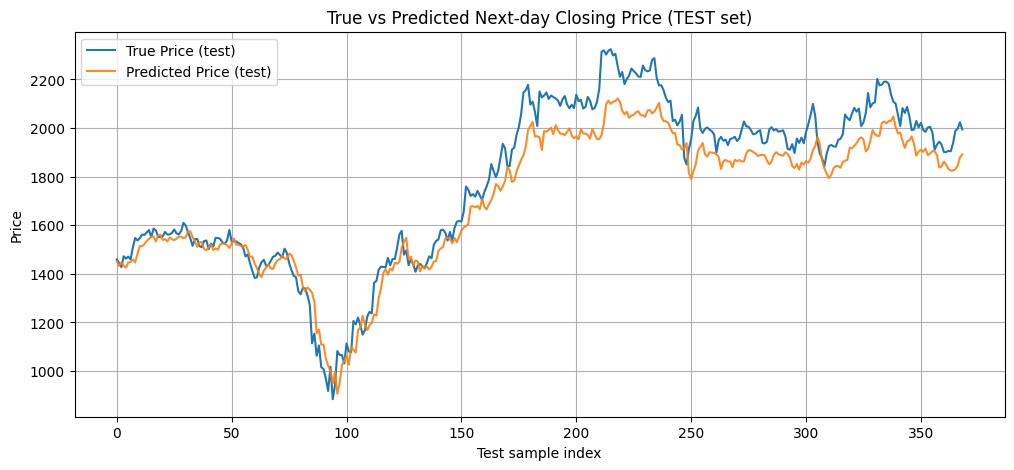

In [3]:
plt.figure(figsize=(12,5))
plt.plot(true_price, label='True Price (test)')
plt.plot(pred_price, label='Predicted Price (test)', alpha=0.9)
plt.title("True vs Predicted Next-day Closing Price (TEST set)")
plt.xlabel("Test sample index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()